In [760]:
library(tidyverse)
library(cowplot)

x <- read_csv("HelperScripts/Data/Non_assembly/sp_num_a_sig_0.0.csv", col_names = c("-0.65","0.0","0.65") , col_types = cols()) %>%
    mutate(sigma = "0.0", T = seq(-1,1,length.out = 25)) %>%
    pivot_longer(c(-sigma,-T))

y <- read_csv("HelperScripts/Data/Non_assembly/sp_num_a_sig_0.5.csv", col_names = c("-0.65","0.0","0.65") , col_types = cols()) %>%
    mutate(sigma = "0.5", T = seq(-1,1,length.out = 25)) %>%
    pivot_longer(c(-sigma,-T))

z <- read_csv("HelperScripts/Data/Non_assembly/sp_num_a_sig_1.0.csv", col_names = c("-0.65","0.0","0.65") , col_types = cols()) %>%
    mutate(sigma = "1.0", T = seq(-1,1,length.out = 25)) %>%
    pivot_longer(c(-sigma,-T))

cols <- c("0.0" =  "red", "0.5" = "#56B4E9", "1.0" = "#009E73")
annotations <- data.frame(mean = c("-0.65","0.0","0.65"), lab = c("mu[E] == -0.65","mu[E] == 0.0","mu[E] == 0.65"))


DT_to_T <- function(T, Tref){
    return( (1 / (((8.617e-5) * T) + (1/Tref))) - 273.15)
}


p1 <- bind_rows(x,y,z) %>%
    rename(mean = name) %>%
    mutate(T = DT_to_T(T, 288)) %>%
    ggplot() +
        geom_line(aes(x = T, y = value, group = sigma, color = sigma)) + 
        geom_text(data = annotations, aes(label = lab),x = 15, y = 20, size = 9, parse = TRUE)+
        facet_wrap(~ mean)+
        scale_color_manual(values = cols, name = expression(sigma[E]))+
        xlab(expression(Temperature  *degree*C)) + ylab("Species Richness, N")+
        theme_bw()+
        theme(strip.background = element_blank(),
              strip.text = element_blank(),
             legend.position = c(0.78,0.35),
              legend.text = element_text(size = 20),
              legend.title = element_text(size = 20), 
             axis.text = element_text(size = 12),
             axis.title = element_text(size = 20))

In [761]:
p2 <- read_csv("HelperScripts/Data/Non_assembly/sp_num_k.csv", col_types = cols(), col_names = c("0.0","0.5","1.0")) %>%
    mutate(T = seq(-1,1,length.out = 25)) %>%
    pivot_longer(-T) %>%
    mutate(T = DT_to_T(T, 288)) %>%
    rename(sigma = name) %>%
    ggplot(aes(x = T, y = value, color = sigma, group = sigma))+
        geom_line()+
        scale_color_manual(values = cols, name = expression(sigma[E]))+
        xlab(expression(Temperature  *degree*C)) + ylab("")+
        theme_bw()+
            theme(strip.background = element_blank(),
              strip.text = element_blank(),
             legend.position = "none",
              legend.text = element_text(size = 20),
              legend.title = element_text(size = 20), 
             axis.text = element_text(size = 12),
             axis.title = element_text(size = 20))

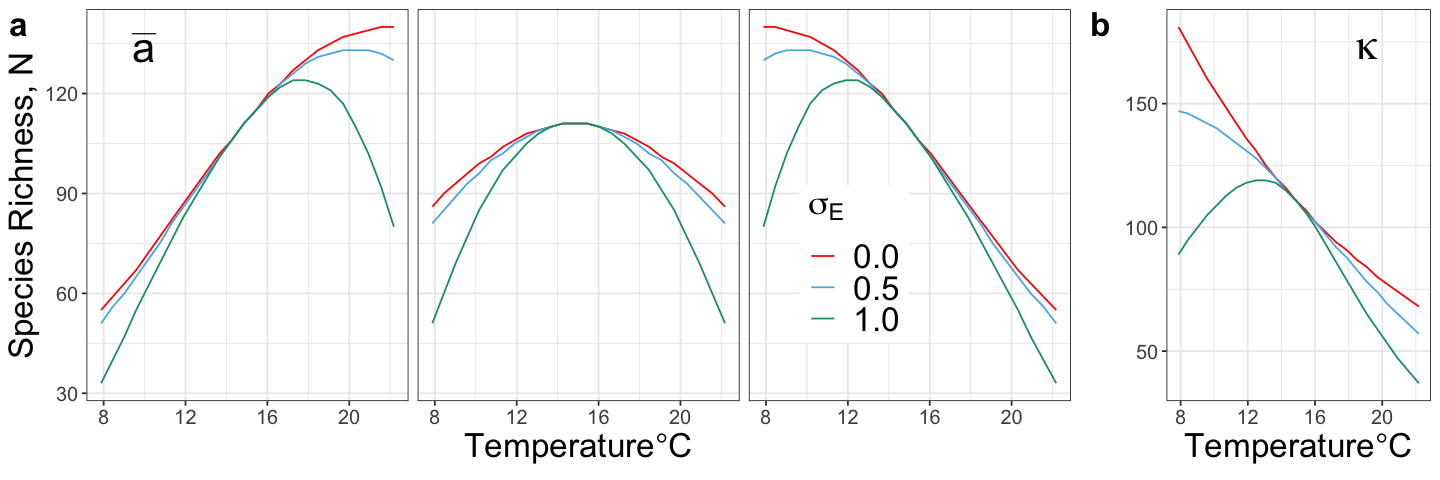

In [762]:
options(repr.plot.width = 12, repr.plot.height = 4)

p_final <- plot_grid(p1,p2, nrow = 1, rel_widths = c(0.75,0.25),labels = "auto", axis = "b" ,align = "h",label_size = 20)+
draw_label(expression(bar(a)), 0.1,0.9, size = 25)+
draw_label(expression(kappa),  0.95,0.9, size = 25)

p_final

In [764]:
ggsave("../docs/Figures/Fig_N_ana.pdf", p_final, width = 12, height = 4)

# Simualtion Results


In [765]:
#read N vs T
files <- list.files("HelperScripts/Data/Assembly/N_time/")
data <- list()

for(i in 1:length(files)){
    x = files[i] %>% str_split("_")
    rep <- x[[1]][4] %>% as.numeric
    temp <- x[[1]][6] %>% gsub(x = ., pattern = ".csv", replacement = "") %>% as.numeric %>% DT_to_T(., 288)

    data[[i]] <- read_csv(paste0("HelperScripts/Data/Assembly/N_time/",files[i]),col_types = cols(), col_names = c("N","t")) %>%
    mutate(Temp = temp, Rep = rep, t = cumsum(t))
}

data_NvT <- bind_rows(data)

In [766]:
#read N_end
T <- read_csv("HelperScripts/Data/Assembly/Temp.csv", col_types = cols(), col_names = "T")

N_end <- list()
for(i in 1:3){
N_end[[i]] <- read_csv(paste0("HelperScripts/Data/Assembly/N_end_",i,".csv"),col_types = cols(), col_names = as.character(T$T)) %>%
    mutate(Rep = 1:20) %>%
    pivot_longer(-Rep,names_to = "Temp", values_to = "N") %>%
    mutate(Temp = as.numeric(Temp), sigma = c(0.0,0.25,0.5)[i]) 
}

N_end_pred <- read_csv("HelperScripts/Data/Assembly/pred.csv",
                       col_types = cols(),
                       col_names = as.character(c(0,0.25,0.5))) %>%
    mutate(Temp = T$T) %>%
    pivot_longer(-Temp, names_to = "sigma", values_to = "N") %>%
    mutate(sigma = as.numeric(sigma))

N_end_obs <- bind_rows(N_end) %>%
    group_by(Temp, sigma) %>%
    summarise(N_avg = mean(N), min = quantile(N, 0.95), max = quantile(N, 0.05))

`summarise()` regrouping output by 'Temp' (override with `.groups` argument)



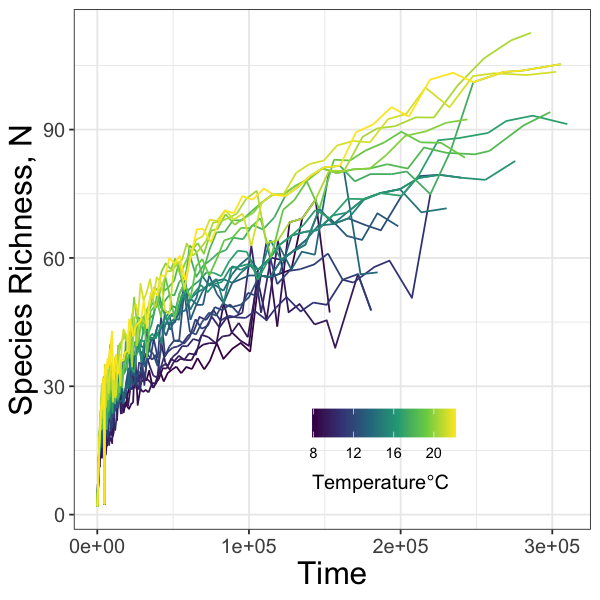

In [767]:
options(repr.plot.width = 5, repr.plot.height = 5)

p_Nvt <- data_NvT %>%
    group_by(Temp) %>%
    mutate(t_bin = cut(t,exp(seq(0,log(max(t)),length.out = 200)))) %>%
    group_by(t_bin) %>%
    mutate(t_avg = mean(t),N_avg = mean(N)) %>%
    ggplot(aes(x = t_avg, y = N_avg, color = Temp, group = Temp))+
        geom_line()+
        scale_color_viridis_c(name = expression(Temperature  *degree*C),
                              guide = guide_colorbar(direction = "horizontal",
                              title.position = "bottom"))+
        xlab("Time") + ylab("Species Richness, N")+
        theme_bw()+
        theme(legend.position = c(0.6, 0.15),
            axis.text = element_text(size = 12),
              legend.title = element_text(size = 12),
                legend.background = element_blank(),
              axis.title = element_text(size = 19))
p_Nvt

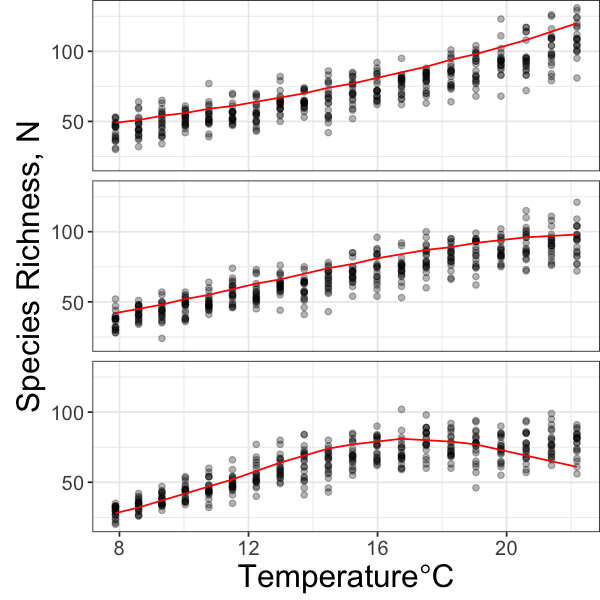

In [781]:
options(repr.plot.width = 5, repr.plot.height = 5)

p_N_end <- bind_rows(N_end) %>%
    ggplot(aes(x= DT_to_T(Temp, 288.0), y = N))+
        geom_point(alpha = 0.3)+
        geom_line(data = N_end_pred, color = "red")+
        xlab(expression(Temperature  *degree*C)) +
        ylab("Species Richness, N")+
        facet_wrap(~sigma, nrow = 3,)+
        theme_bw()+
        theme(plot.margin = margin(0,0,0,10),
            strip.background = element_blank(),
              strip.text = element_blank(),
              axis.text = element_text(size = 12),
              legend.title = element_text(size = 12),
              axis.title = element_text(size = 19))



p_N_end

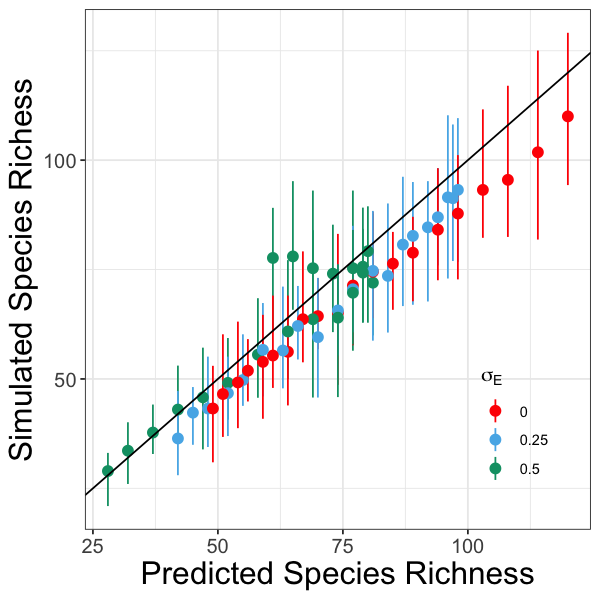

In [782]:
N_end_pred$N_obs <- N_end_obs$N_avg
N_end_pred$min <- N_end_obs$min
N_end_pred$max <- N_end_obs$max

N_end_pred$Temp_obs <- N_end_obs$Temp

cols <- c("0" =  "red", "0.25" = "#56B4E9", "0.5" = "#009E73")


N_obs <- N_end_pred %>%
    ggplot(aes(x = N,y = N_obs, color = as.factor(sigma)))+
        geom_pointrange(aes(ymin = min, ymax = max))+
        geom_abline()+
        xlab("Predicted Species Richness") +
        ylab("Simulated Species Richess") +
        theme_bw()+
        scale_color_manual(values = cols, name = expression(sigma[E]))+
        theme(legend.background = element_blank(),
            legend.position = c(0.85,0.2),
              axis.text = element_text(size = 12),
              legend.title = element_text(size = 12),
              axis.title = element_text(size = 19))

N_obs

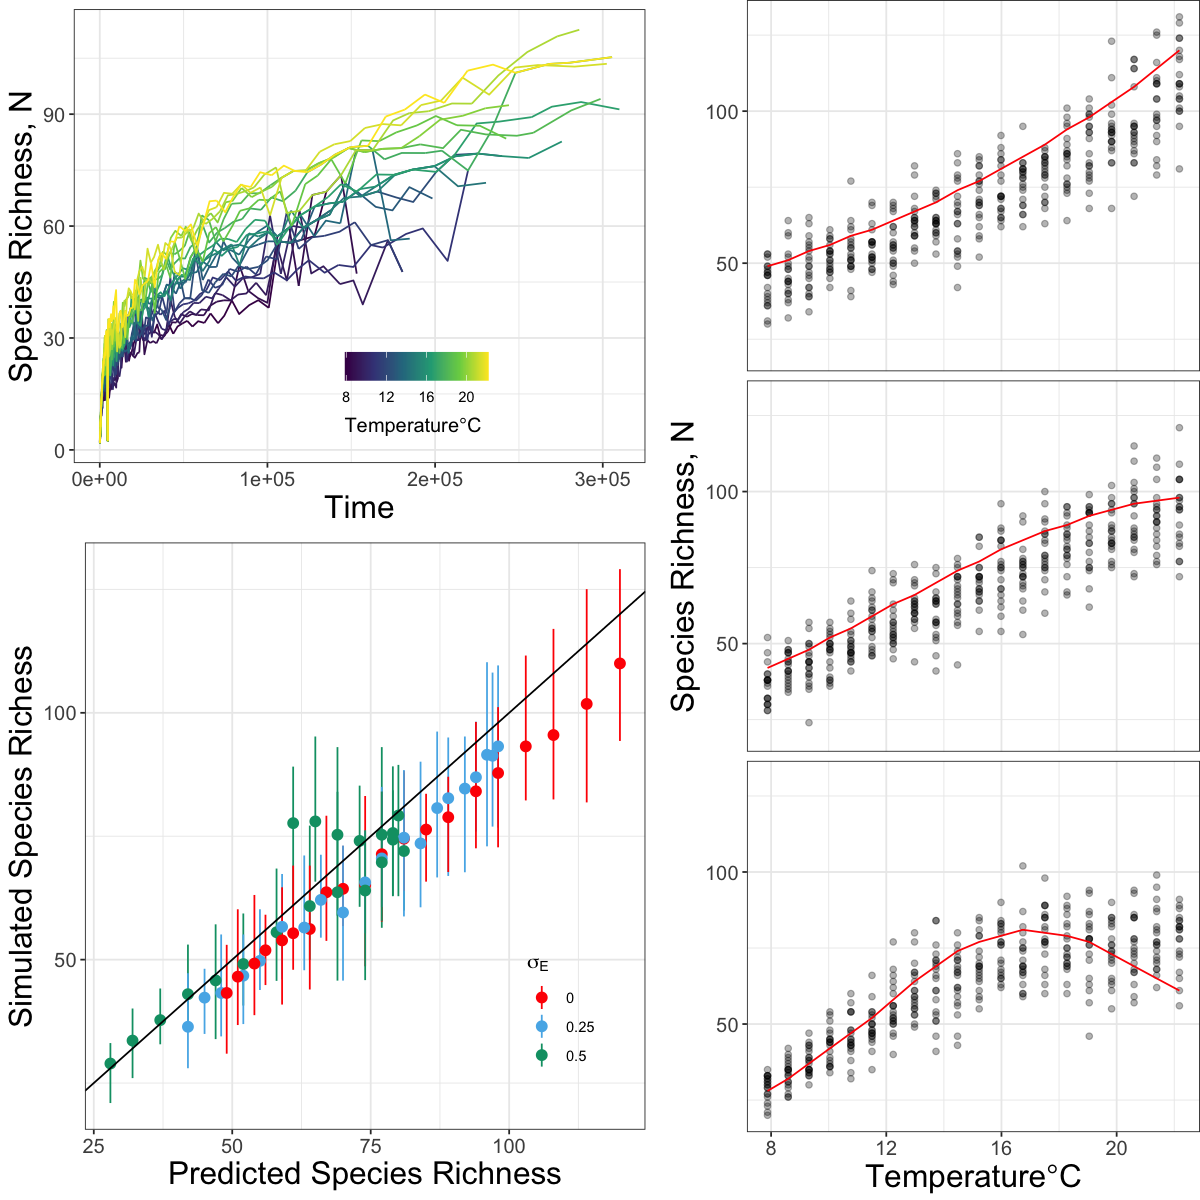

In [783]:
options(repr.plot.width = 10, repr.plot.height = 10)

p <- plot_grid(p_Nvt,N_obs, nrow = 2, rel_heights = c(0.8,1))
p_final <- plot_grid(p, p_N_end, rel_widths = c(1.2,1))

p_final

In [784]:
ggsave("../docs/Figures/Fig_sim.pdf",width = 8, height = 8)